<a href="https://colab.research.google.com/github/anmolray/DiffusionModel/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



Data source import complete.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

# enable cuDNN autotuner
torch.backends.cudnn.benchmark = True

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type=="cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [ ]:
base_dir ='/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE   = 256
BATCH_SIZE = 32
EPOCHS     = 150
timesteps  = 16


# noise schedule for your two-step forward_noise
time_bar = 1 - np.linspace(0,1.0, timesteps+1)


In [ ]:
# after you define time_bar (numpy array of length T+1):
tb = torch.from_numpy(time_bar).float().to(device)
betas = 1 - (tb[1:] / tb[:-1])
betas = betas.clamp(0, 0.999)                          # safety
alphas = 1 - betas                                     # alphas from paper
alphas_cumprod = torch.cumprod(alphas, dim=0)         # cumulative product of alphas

In [ ]:
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])
test_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=test_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
print(train_ds.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
def generate_ts(batch_size):
    return np.random.randint(0, timesteps, size=batch_size)

def forward_noise(x0, t_np):
    t = torch.from_numpy(t_np).long().to(device)
    # √ᾱₜ and √(1−ᾱₜ)
    sa = alphas_cumprod[t].sqrt().view(-1,1,1,1)
    sb = (1 - alphas_cumprod[t]).sqrt().view(-1,1,1,1)
    noise = torch.randn_like(x0)
    x_t = sa * x0 + sb * noise
    return x_t, noise, t

In [ ]:
# U-Net to mimic Diffusion Process
# The model needs to be aware of time, so it knows how noisy the input is.
#	It needs to be aware of class, so it knows what kind of image to produce.
import torch.nn as nn
import torch.nn.functional as F

class CondBlock(nn.Module):
  # Core building block, used for the encoding portion of the image
    def __init__(self, in_ch, size):
        super().__init__()
        # Each block applies two convolutions
        self.conv1    = nn.Conv2d(in_ch, 128, 3, padding=1)
        self.conv2    = nn.Conv2d(in_ch, 128, 3, padding=1)
        # Simple NN to embed class, noise at timestep t
        self.time_mlp = nn.Sequential(
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )
        self.norm     = nn.LayerNorm([128, size, size])

    def forward(self, x, cond_emb):
        x_param = F.relu(self.conv1(x))               # [B,128,H,W]
        t       = self.time_mlp(cond_emb).view(-1,128,1,1)
        x_param = x_param * (1 + t)
        x_out   = self.conv2(x)                       # [B,128,H,W]
        return self.norm(x_out + x_param)


class CondDiffusionUNet(nn.Module):
  # This wraps the full encoder-bottleneck-decoder structure
    def __init__(self, img_size=256, n_classes=2):
        super().__init__()
        # embed timestep
        self.t_mlp     = nn.Sequential(nn.Linear(1,192), nn.ReLU())
        # embed class
        self.c_emb     = nn.Embedding(n_classes, 192)

        # downsample path (compress features by 2, inject conditioning in each layer to determine patterns adapt denoising)
        self.down1     = CondBlock(1,   img_size)
        self.down2     = CondBlock(128, img_size//2)
        self.down3     = CondBlock(128, img_size//4)
        self.down4     = CondBlock(128, img_size//8)

        # bottleneck MLP
        flat = 128*(img_size//8)*(img_size//8) + 192 # flatten the final spatial output
        mid  = 512
        out  = 32*(img_size//16)*(img_size//16)
        self.bottleneck = nn.Sequential(
            nn.Linear(flat, mid), nn.ReLU(),
            nn.Linear(mid, out),  nn.ReLU()
        ) # output reshaped for upsampling through bottleneck layer

        # upsample path
        self.up4       = CondBlock(32+128, img_size//8)
        self.up3       = CondBlock(128+128,img_size//4)
        self.up2       = CondBlock(128+128,img_size//2)
        self.up1       = CondBlock(128+128,img_size)

        self.final     = nn.Conv2d(128, 1, 1) # final dims, models prediction for noise
        self.opt       = torch.optim.AdamW(self.parameters(), lr=8e-4) # Adam Optimizer

    def forward(self, x, t, y):
        # x: [B,1,H,W], t: [B], y: [B]
        t_e = self.t_mlp(t.float().view(-1,1))     # → [B,192]
        c_e = self.c_emb(y)                       # → [B,192]
        cond = t_e + c_e                          # fused embedding

        # down
        d1 = self.down1(x,   cond); p1 = F.max_pool2d(d1,2)
        d2 = self.down2(p1,  cond); p2 = F.max_pool2d(d2,2)
        d3 = self.down3(p2,  cond); p3 = F.max_pool2d(d3,2)
        d4 = self.down4(p3,  cond)

        # bottleneck
        flat = torch.cat([d4.view(d4.size(0),-1), cond], dim=1)
        b    = self.bottleneck(flat).view(-1,32, IMG_SIZE//16, IMG_SIZE//16)

        # up (Resolution is doubled at each stage using Interpolate)
        u4 = F.interpolate(b, scale_factor=2)
        u4 = self.up4(torch.cat([u4,d4],1), cond)
        u3 = F.interpolate(u4,scale_factor=2)
        u3 = self.up3(torch.cat([u3,d3],1), cond)
        u2 = F.interpolate(u3,scale_factor=2)
        u2 = self.up2(torch.cat([u2,d2],1), cond)
        u1 = F.interpolate(u2,scale_factor=2)
        u1 = self.up1(torch.cat([u1,d1],1), cond)

        return self.final(u1)


model = CondDiffusionUNet(IMG_SIZE, n_classes=2).to(device)
optimizer = model.opt

In [ ]:
import torch
import matplotlib.pyplot as plt

# 1) p_sample_cond: one reverse‐diffusion step
# This function performs a single step of denoising at timestep t, conditioned on a class label and how much noise is in the image at t
@torch.no_grad()
def p_sample_cond(model, x_t, t, y):
    # debug print
    #print("reverse step t=", t.cpu().numpy())
    eps = model(x_t, t, y)
   # Extract the noise schedule variables for timestep t
    beta_t      = betas[t].view(-1,1,1,1)
    alpha_t     = alphas[t].view(-1,1,1,1)
    alpha_cum_t = alphas_cumprod[t].view(-1,1,1,1)

    prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]], dim=0)
    alpha_cum_prev = prev[t].view(-1,1,1,1)

    mean = (1/alpha_t.sqrt()) * (x_t - (beta_t/(1-alpha_cum_t).sqrt())*eps) # This is the predicted mean of the denoised image at step t-1, using equations DDPM
    var  = beta_t * (1-alpha_cum_prev)/(1-alpha_cum_t)
    noise = torch.randn_like(x_t) if (t>0).any() else torch.zeros_like(x_t)
    return mean + var.sqrt() * noise # returns sample from Gaussian Distribution

# 2) sample_images_cond: generating an image from pure noise all the way back to something meaningful.
@torch.no_grad()
def sample_images_cond(model, label, n_samples=9):
  # Generate a Pneumonia chest X-ray from noise

    x = torch.randn(n_samples,1,IMG_SIZE,IMG_SIZE,device=device)
    y = torch.full((n_samples,), label, dtype=torch.long, device=device)
    for t in reversed(range(timesteps)): # applies p_sample_cond for t=T, to t=1, each step denoises image to give clearer image
        t_vec = torch.full((n_samples,), t, dtype=torch.long, device=device)
        x = p_sample_cond(model, x, t_vec, y)
    return x.clamp(-1,1)

#Visualizing Functions
def show_examples(x, n=9):
    imgs = x[:n].add(1).div(2).cpu().permute(0,2,3,1).numpy()
    fig, axs = plt.subplots(3,3,figsize=(6,6))
    for i,ax in enumerate(axs.flatten()):
        ax.imshow(imgs[i].squeeze(), cmap='gray'); ax.axis('off')
    plt.show()


def predict(label=0, n=9):
    out = sample_images_cond(model, label, n_samples=n)
    show_examples(out, n)


def predict_step(label=0, record_steps=None):
    if record_steps is None:
        record_steps = [0, timesteps//4, timesteps//2, 3*timesteps//4, timesteps-1]
    x = torch.randn(1,1,IMG_SIZE,IMG_SIZE,device=device)
    y = torch.full((1,), label, dtype=torch.long, device=device)
    frames = {}
    for t in reversed(range(timesteps)):
        t_vec = torch.full((1,), t, dtype=torch.long, device=device)
        x = p_sample_cond(model, x, t_vec, y)
        if t in record_steps:
            frames[t] = x[0].clamp(-1,1).add(1).cpu().squeeze().numpy()
    plt.figure(figsize=(len(frames)*2,2))
    for i,t in enumerate(sorted(frames)):
        plt.subplot(1,len(frames),i+1)
        plt.imshow(frames[t], cmap='gray'); plt.title(f"t={t}"); plt.axis('off')
    plt.show()

In [ ]:
def train_step(x0, y0):
    model.train()
    x0, y0 = x0.to(device), y0.to(device)

    # sample timesteps and noise
    t_np         = generate_ts(x0.size(0))
    x_a, x_b, t_t = forward_noise(x0, t_np)
    y_t          = y0

    # forward pass
    pred = model(x_a, t_t, y_t)
    # plain L1
    loss = F.l1_loss(pred, x_b)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


import os

folder_path = "saved_models_25timesteps"
os.makedirs(folder_path, exist_ok=True)

for epoch in range(1, EPOCHS+1):
    losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        losses.append(train_step(xb, yb))
    print(f"Epoch {epoch} avg loss: {sum(losses)/len(losses):.4f}")
    torch.save(model.state_dict(), f"{folder_path}/dm_epoch{epoch}.pt")

Epoch 1/50: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


Epoch 1 avg loss: 0.1653


Epoch 2/50: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 2 avg loss: 0.0908


Epoch 3/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 3 avg loss: 0.0831


Epoch 4/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 4 avg loss: 0.0818


Epoch 5/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 5 avg loss: 0.0785


Epoch 6/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 6 avg loss: 0.0775


Epoch 7/50: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 7 avg loss: 0.0760


Epoch 8/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 8 avg loss: 0.0749


Epoch 9/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 9 avg loss: 0.0728


Epoch 10/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 10 avg loss: 0.0713


Epoch 11/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 11 avg loss: 0.0723


Epoch 12/50: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]


Epoch 12 avg loss: 0.0697


Epoch 13/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 13 avg loss: 0.0694


Epoch 14/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 14 avg loss: 0.0684


Epoch 15/50: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 15 avg loss: 0.0676


Epoch 16/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 16 avg loss: 0.0680


Epoch 17/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 17 avg loss: 0.0666


Epoch 18/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 18 avg loss: 0.0660


Epoch 19/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 19 avg loss: 0.0665


Epoch 20/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 20 avg loss: 0.0653


Epoch 21/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 21 avg loss: 0.0651


Epoch 22/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 22 avg loss: 0.0645


Epoch 23/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 23 avg loss: 0.0645


Epoch 24/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 24 avg loss: 0.0648


Epoch 25/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 25 avg loss: 0.0641


Epoch 26/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 26 avg loss: 0.0638


Epoch 27/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 27 avg loss: 0.0640


Epoch 28/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 28 avg loss: 0.0631


Epoch 29/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 29 avg loss: 0.0629


Epoch 30/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 30 avg loss: 0.0621


Epoch 31/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 31 avg loss: 0.0630


Epoch 32/50: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 32 avg loss: 0.0625


Epoch 33/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 33 avg loss: 0.0619


Epoch 34/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 34 avg loss: 0.0628


Epoch 35/50: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 35 avg loss: 0.0619


Epoch 36/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 36 avg loss: 0.0617


Epoch 37/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 37 avg loss: 0.0621


Epoch 38/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 38 avg loss: 0.0617


Epoch 39/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 39 avg loss: 0.0612


Epoch 40/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 40 avg loss: 0.0614


Epoch 41/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 41 avg loss: 0.0609


Epoch 42/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 42 avg loss: 0.0612


Epoch 43/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 43 avg loss: 0.0605


Epoch 44/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 44 avg loss: 0.0603


Epoch 45/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 45 avg loss: 0.0608


Epoch 46/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 46 avg loss: 0.0604


Epoch 47/50: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 47 avg loss: 0.0606


Epoch 48/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 48 avg loss: 0.0607


Epoch 49/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 49 avg loss: 0.0603


Epoch 50/50: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 50 avg loss: 0.0604


<class 'collections.OrderedDict'> 89 keys: ['t_mlp.0.weight', 't_mlp.0.bias', 'c_emb.weight', 'down1.conv1.weight', 'down1.conv1.bias']
✅ state_dict loaded successfully!
=== After 75 Epochs: NORMAL ===


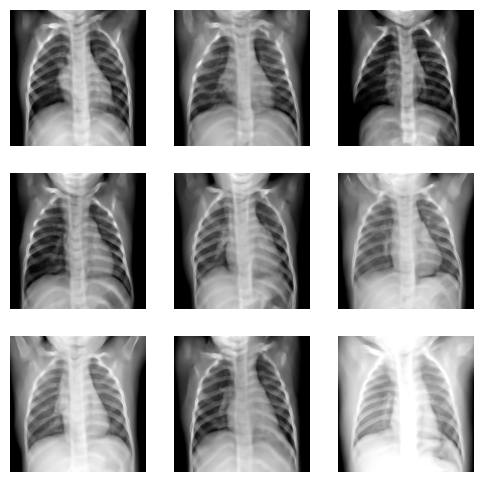

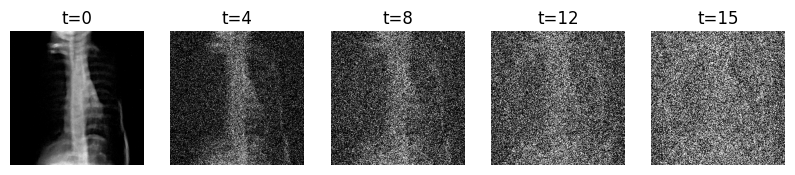

=== After 75 Epochs: PNEUMONIA ===


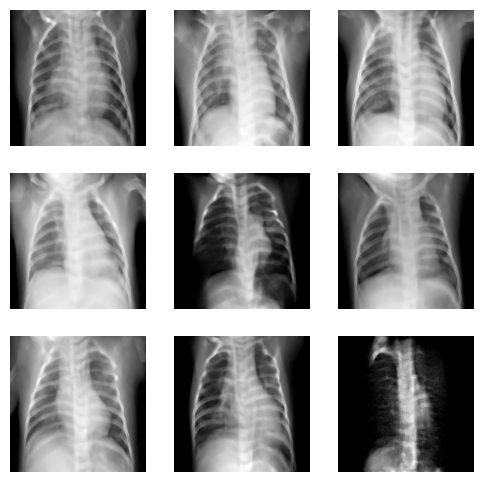

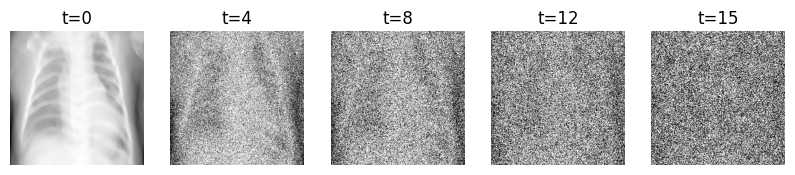

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-instantiate your model architecture
model = CondDiffusionUNet(IMG_SIZE, n_classes=2).to(device)

# prev saved model
ckpt_path = "/content/dm_epoch75.pt"
state_dict = torch.load(ckpt_path, map_location=device)

# Sanity check: it should be a dict of parameter tensors
print(type(state_dict), len(state_dict), 'keys:', list(state_dict.keys())[:5])

# Now load into your model
model.load_state_dict(state_dict)
model.eval()
# Sample a grid of “Normal” lungs
print("=== After 75 Epochs: NORMAL ===")
predict(label=0)

# Step‐by‐step denoising for one Normal example
predict_step(label=0)

# same for Pneumonia
print("=== After 75 Epochs: PNEUMONIA ===")
predict(label=1)
predict_step(label=1)

In [ ]:
torch.save({
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epoch': 75
}, 'dm_checkpoint75.pt')

In [ ]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


# Helpers
def denormalize(t):
    return ((t + 1) / 2).clamp(0, 1)

def compute_ssim_psnr(real, gen):
    real_np = real.squeeze().cpu().numpy()
    gen_np  = gen.squeeze().cpu().numpy()
    return ssim(real_np, gen_np, data_range=1.0), psnr(real_np, gen_np, data_range=1.0)

l1_loss_fn = torch.nn.L1Loss()

# validation loss metrics
all_l1, all_ssim, all_psnr = [], [], []
with torch.no_grad():
    for x_real_batch, y_batch in val_loader:
        x_real = x_real_batch.to(device)
        # iterate each example in the batch
        for i in range(x_real.size(0)):
            img = x_real[i : i+1]                       # shape [1,1,H,W]
            lbl = int(y_batch[i].item())               # scalar 0 or 1

            # generate a single sample conditioned on lbl
            x_gen = sample_images_cond(model, label=lbl, n_samples=1).to(device)

            # denormalize both to [0,1]
            real_dn = denormalize(img)
            gen_dn  = denormalize(x_gen)

            # metrics
            l1_val   = l1_loss_fn(x_gen, img).item()
            ssim_val, psnr_val = compute_ssim_psnr(real_dn, gen_dn)

            all_l1.append(l1_val)
            all_ssim.append(ssim_val)
            all_psnr.append(psnr_val)

# 4) Print averages
print(" Validation Metrics (75th epoch):")
print(f" • L1 Loss : {np.mean(all_l1):.4f}")
print(f" • SSIM    : {np.mean(all_ssim):.4f}")
print(f" • PSNR    : {np.mean(all_psnr):.2f} dB")

 Validation Metrics (75th epoch):
 • L1 Loss : 0.3951
 • SSIM    : 0.3976
 • PSNR    : 13.18 dB
